In [1]:
import warnings
import time
warnings.simplefilter('ignore')

import logging
logging.basicConfig(format='%(levelname)-8s [%(asctime)s] s(%(module)s : %(funcName)s) %(message)s',level=logging.INFO)
logging.info("application started")
logging.info("")
logging.info("")
# будем отображать графики прямо в jupyter'e
%pylab inline
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import re
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,roc_auc_score
from sklearn.preprocessing import StandardScaler



sns.set(rc=rcParams)
sns.set_style("darkgrid", {
    "axes.facecolor": "#282828",
    "axes.edgecolor":"#282828",
    "grid.color":"#298F4A",
    "xtick.color":"1",
    "ytick.color":"1",
    "text.color":"1",
    "axes.labelcolor":"1",
    "figure.facecolor":"#282828"
})
sns.set_palette(sns.color_palette("BrBG", 7))

INFO     [2017-07-20 18:06:11,409] s(<ipython-input-1-d62e589e0fea> : <module>) application started
INFO     [2017-07-20 18:06:11,413] s(<ipython-input-1-d62e589e0fea> : <module>) 
INFO     [2017-07-20 18:06:11,416] s(<ipython-input-1-d62e589e0fea> : <module>) 


Populating the interactive namespace from numpy and matplotlib


/home/azaz/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-20 18:06:11.357523. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [2]:
import json
from pprint import pprint
from collections import defaultdict

repl=json.load(open('./DataForTest/field_alpha.txt'))
qwe=dict()
for r in repl:
    d=r['clauseNames']
    if len(d)>1:
        qwe['customfield_'+d[0][3:-1]]=d[1]
created=[]

for (root,dirs,files) in os.walk('./DataForTest/'):
    for file in files:
        if file=='issue.txt':
            with open(root+"/"+file) as data_file:    
                data = json.load(data_file)
                created.append(data['issues'][0]['fields']['created'])

/home/azaz/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-20 18:06:13.415777. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


,one
date,
2011-10-31 20:00:00,1
2011-11-02 20:00:00,1
2011-11-04 20:00:00,1
2011-11-06 20:00:00,1
2011-11-07 20:00:00,4
2011-11-13 20:00:00,1
2011-11-15 20:00:00,1
2011-11-21 20:00:00,1
2011-12-11 20:00:00,1


,one
date,
2011-11-06,4.0
2011-11-20,6.0
2011-12-04,1.0
2011-12-18,1.0
2012-01-01,5.0
2012-01-15,2.0
2012-01-29,7.0
2012-02-12,9.0
2012-02-26,4.0


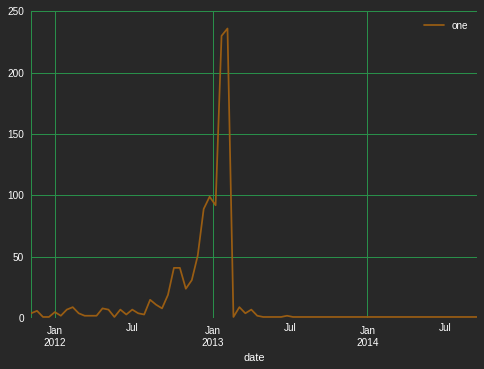

/home/azaz/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-20 18:06:15.457569. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [3]:
asd=pd.DataFrame(created,columns=['date'])
asd['date']=pd.to_datetime(asd['date'])
asd['one']=1
asd.sort('date',inplace=True)
asd=asd.groupby('date').sum()
asd.head(10)

qqq=asd.resample('2W',how='sum',fill_method='bfill')
qqq.plot()
qqq

In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,roc_auc_score
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.ensemble import AdaBoostRegressor,ExtraTreesRegressor,BaggingRegressor
from sklearn.linear_model import LinearRegression

X=qqq.iloc[:-13].values

X=normalize(X,axis=0,norm='max')
Y=X[1:]
X=X[:-1]

from sklearn.utils import shuffle
Xn,Yn=shuffle(X,Y,random_state=123)
Xtrain,Xtest,Ytrain,Ytest=train_test_split(Xn,Yn,test_size=0.3,random_state=123)

/home/azaz/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-20 18:06:16.305234. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
parameters ={
    'learning_rate':np.linspace(0.01,0.2,5),
    'max_depth':range(1,20,2),
    'subsample':np.linspace(0.1,1,5),
    "n_estimators":range(1,100,15)
}

# dtrain = xgb.DMatrix(trainPairX,trainPairY)
# dtest = xgb.DMatrix(testPairX,testPairY)

grid=GridSearchCV(xgb.XGBRegressor(),parameters,verbose=1,n_jobs=4,scoring=make_scorer(mean_squared_error))
grid.fit(Xtrain,Ytrain)
grid.best_params_

Fitting 3 folds for each of 1750 candidates, totalling 5250 fits


[Parallel(n_jobs=4)]: Done 628 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 3928 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done 5250 out of 5250 | elapsed:   19.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'learning_rate': array([ 0.01  ,  0.0575,  0.105 ,  0.1525,  0.2   ]), 'max_depth': range(1, 20, 2), 'n_estimators': range(1, 100, 15), 'subsample': array([ 0.1  ,  0.325,  0.55 ,  0.775,  1.   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_squared_error), verbose=1)

{'learning_rate': 0.01,
 'max_depth': 1,
 'n_estimators': 1,
 'subsample': 0.10000000000000001}

(0.88520771422109013, '%')

(0.87440181177940202, '%')

array([ 0.04966664], dtype=float32)

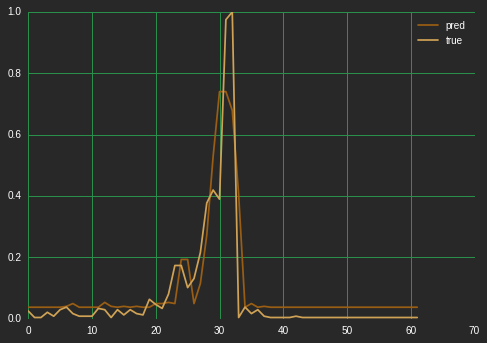

'========================================================================================================================'

In [5]:
reg=xgb.XGBRegressor(**
{'learning_rate': 0.050000000000000003,
 'max_depth': 2,
 'n_estimators': 96,
 'subsample': 0.10000000000000001}
)

reg=xgb.XGBRegressor(**{'n_estimators':30,"learning_rate":0.1,"max_depth":3,"subsample":0.5})


bst=reg.fit(Xtrain,Ytrain)
mean_squared_error(bst.predict(Xtrain),Ytrain)*100,'%'
mean_squared_error(bst.predict(Xtest),Ytest)*100,'%'
bst.predict([Xtest[0]])
bst.get_booster().dump_model('dump_2Wresample(sum)_.raw.txt')
plt.plot(bst.predict(X))
plt.plot(Y)
plt.legend(['pred','true'])
plt.show()

"="*120